In [260]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d,PchipInterpolator

In [261]:
def walsh(order,x):
    res = 1
    x = np.modf(x)[0]
    x *= 2
    while order>0:
        res *= (-1)**((order%2)*np.modf(x)[1])
        order //= 2
        x = np.modf(x)[0]
        x *= 2
    return res

def walsh_coeff(f,order,M):
    sampling_points = np.linspace(0,1,num=M,endpoint=False)
    sampled_values = [walsh(order,i) for i in sampling_points]
    return np.dot(f(sampling_points),sampled_values)/M

def walsh_approximator(f,n,max_terms=1024):
    #Returns a function f^eps, the Walsh approximation of f
    # m = np.floor(np.log2(1/eps))+1
    M = int(2**n)
    # print('This is M',M)
    all_coeffs = [walsh_coeff(f,j,M) for j in range(M)]
    #Keep only largest max_terms coeffs sorted by absolute value
    largest = sorted(zip(np.abs(all_coeffs),all_coeffs,range(M)),reverse=True)[:max_terms]
    coeffs = [coeff for _,coeff,idx in largest]
    orders = [idx for _,coeff,idx in largest]
    def approximated_f(x):
        values = [walsh(j,x) for j in orders]
        return np.dot(coeffs,values)
    return approximated_f, coeffs, orders

def get_interp(amp_list):
    return PchipInterpolator(np.linspace(0,1,num=amp_list.shape[0],endpoint=False),amp_list)

In [728]:
def walsh_operator(wires,ancilla,coeff,eps0):
    for q in wires[:-1]:
        qml.Toffoli([ancilla,q,wires[-1]])
    qml.CRZ(-2*coeff*eps0,wires=[ancilla,wires[-1]])
    for q in reversed(wires[:-1]):
        qml.Toffoli([ancilla,q,wires[-1]])

def walsh_unitary(f,wires,ancilla,eps0,k,max_terms):
    approx_f,coeffs,orders = walsh_approximator(f,k,max_terms)
    # print(coeffs)
    # print(orders)
    def unitary_circuit():
        for wire in wires:
            qml.Hadamard(wire)
        qml.Hadamard(ancilla)
        for coeff,order in zip(coeffs,orders):
            bin_ord = list(np.binary_repr(order,width=len(wires)))
            bin_ord.reverse()
            bin_ord = np.array(bin_ord)
            indices = np.where(bin_ord == '1')
            # print(order,indices)
            on_wires = np.take_along_axis(np.array(wires),indices[0],0)
            if order>0:
                walsh_operator(on_wires,ancilla,coeff,eps0)
        zero_coeff = np.array(coeffs)[np.nonzero(np.array(orders)==0)]
        if zero_coeff.size > 0:
            qml.RZ(-2*zero_coeff[0]*eps0,wires=ancilla)
        qml.Hadamard(ancilla)
        qml.adjoint(qml.S)(ancilla)
    return unitary_circuit

def U3(wires,ancilla,unitary):
    qml.adjoint(unitary)()
    qml.ctrl(qml.PauliZ,wires,control_values=[False]*len(wires))(ancilla[0])
    unitary()

def Utot(wires,ancilla,unitary):
    qml.PauliZ(ancilla[0])
    U3(wires,ancilla,unitary)

def walsh_state_prep(wires,ancilla,f,eps0,k,reps,max_terms):
    unitary = walsh_unitary(f,wires,ancilla[0],eps0,k,max_terms)
    sampled_points = f(np.linspace(0,1,num=2**k,endpoint=False))
    for i in range(reps):
        Utot(wires,ancilla,unitary)

In [729]:
num_qubits = 4
dev = qml.device('default.qubit',wires=num_qubits+1)
@qml.qnode(dev)
def circuit(wires,ancilla,f,eps0,k,reps,max_terms=10**9):
    walsh_state_prep(wires,ancilla,f,eps0,k,reps,max_terms)
    return qml.state()

In [730]:
amp_list = np.random.normal(0,1,2**num_qubits)
amp_list = np.abs(amp_list)/np.linalg.norm(amp_list)
print(amp_list)

[0.26253635 0.02667963 0.02158532 0.39887079 0.07105836 0.06498362
 0.01910078 0.20537891 0.07653168 0.26569577 0.06028526 0.5708979
 0.17148352 0.37117034 0.34262685 0.16853574]


In [777]:
res = circuit(range(1,num_qubits+1),[0],get_interp(amp_list),5.5,num_qubits,1)

In [783]:
res_p = res[res.shape[0]//2:]
print(np.linalg.norm(res_p))
res_pn = np.abs(res_p)/np.linalg.norm(res_p)
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
theta = np.arcsin(1-(np.max(get_interp(amp_list)(sample_points))*5.5/2)
print(kk)
plt.plot(sample_points,res_pn,label='measured')
plt.plot(sample_points,get_interp(amp_list)(sample_points),label='real',linestyle='--')
plt.scatter(sample_points,amp_list,c='red',zorder=2)
plt.legend()
plt.grid()
plt.show()

SyntaxError: invalid syntax (1929678639.py, line 6)

13 0.2824451208484409


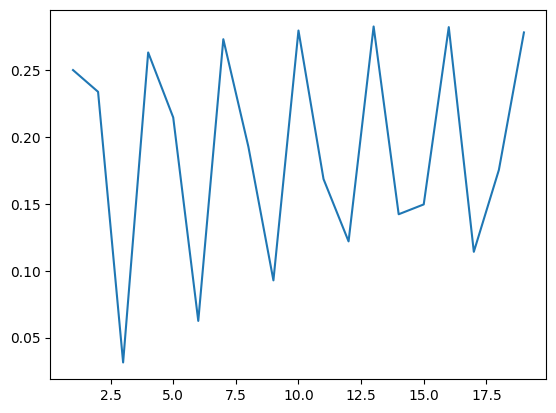

In [711]:
amplitude = []
for i in range(1,20):
    res = circuit(range(1,num_qubits+1),[0],get_interp(amp_list),5.92,num_qubits,i)
    res_p = res[res.shape[0]//2:]
    amplitude.append(np.linalg.norm(res_p))
print(np.argmax(amplitude)+1,np.max(amplitude))
plt.plot(range(1,20),amplitude)

0.17467605677235695 10


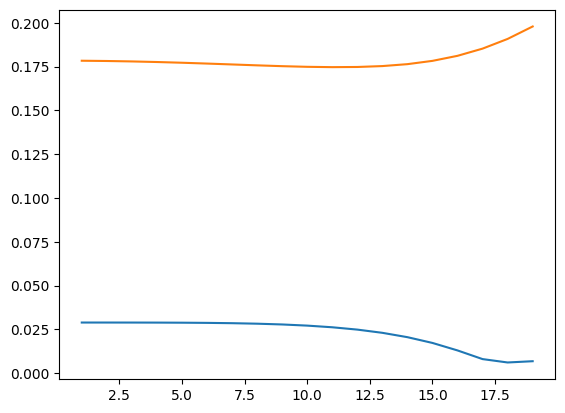

In [479]:
sample_points = np.linspace(0,1,num=2**num_qubits,endpoint=False)
mean_error = []
max_error = []
for i in range(1,20):
    res = circuit(range(1,num_qubits+1),[0],get_interp(amp_list),i,num_qubits,1)
    res_p = res[res.shape[0]//2:]
    res_pn = np.abs(res_p)/np.linalg.norm(res_p)
    mean_error.append(np.mean(res_pn-get_interp(amp_list)(sample_points)))
    # print(np.max(np.abs(res_pn-get_interp(amp_list)(sample_points))))
    lol = (res_pn-get_interp(amp_list)(sample_points))
    max_error.append(np.max(np.abs(lol)))
    # max_error.append(np.max(np.abs((res_pn-get_interp(amp_list)(sample_points))/get_interp(amp_list)(sample_points))))
# print(mean_error)
# print(max_error)
print(np.min(max_error),np.argmin(max_error))
plt.plot(range(1,20),mean_error)
plt.plot(range(1,20),max_error)